In [1]:
import sys
import argparse
import os
import numpy as np
from scipy.signal import get_window
from skimage.util import view_as_windows
from utilities.config_handler import get_config
from utilities.visualization import plot_spectogram
from utilities.learning import split_train_validation, train_model, predict_ae_error_vectors
from utilities.detection import detect_reconstruction_anomalies_median,plot_spectogram_anomalies
from utilities.preprocessing import  add_noise,load_fft_test_data ,load_fft_train_data,  reshape_to_blocks,persist_object\
    ,load_object,persist_val_stat, load_val_stat ,get_xhdr_sample_rate , compute_fft_train_data , load_raw_data , compute_fft_train_data \
, compute_fft_test_data,trim_iq_basic_block, complex2power
import matplotlib.pyplot as plt
from sklearn import mixture
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin_min
from scipy.stats import entropy
from scipy.signal import medfilt
from scipy.signal import welch
from scipy.fftpack import fft,rfft,fftshift,fft2
%matplotlib inline

Using TensorFlow backend.


In [14]:
parser = argparse.ArgumentParser()
parser.prog = 'Spectrum Anomaly Detection'
parser.description = 'Use this command parser for training or testing the anomaly detector'
parser.add_argument('-m', '--mode', help='train or test mode', choices=['train', 'test'])
parser.add_argument('-d', '--data-dir', help='I/Q recording directory')
parser.add_argument('-w', '--weights-path', help='path for trained weights')


sys.argv = "-m test -d iq_data/CELL/normal/CELL_NORM_4 -w model/baseline_cepstrum".split()
# sys.argv = "-m train -d iq_data/CELL/normal/CELL_NORM_2 -w model/baseline_cepstrum".split()

namespace = parser.parse_args(sys.argv)
if not namespace.data_dir and namespace.mode == 'train':
    parser.error('the -d arg must be present when mode is train')
if not namespace.weights_path and namespace.mode == 'train':
    parser.error('the -w arg must be present when mode is train')

if not namespace.data_dir and namespace.mode == 'test':
    parser.error('the -d arg must be present when mode is test')
if not namespace.weights_path and namespace.mode == 'test':
    parser.error('the -w arg must be present when mode is test')
    
train = namespace.mode == 'train'

In [15]:
conf=get_config()
gpus = conf['gpus']
lr=conf['learning']['ae']['lr']
validation_split = conf['learning']['ae']['validation_split']
train_params = conf['learning']['ae']
rbw_set = conf['preprocessing']['ae']['rbw_set']
feature_names = conf['preprocessing']['ae']['feature_names']
fft_window_name = conf['preprocessing']['ae']['window']
basic_block_interval = conf['preprocessing']['basic_time']


fraction = 0.2
num_clusters = 1000
data_dir = namespace.data_dir
median_kernel_size = 11
cepstrum_window_size = 1024
f_s = get_xhdr_sample_rate(data_dir)
test_window_time = 10e-6
cv_types = ['diag']

assert len(data_dir) != 0
dataset_name = str.split(data_dir, '/')[1]
recording_name = str.split(data_dir,'/')[-1]

In [16]:
def compute_frequency_spectrum(freq):
    num_samples = len(freq)
    freq = freq - np.mean(freq)
    window = get_window(fft_window_name, num_samples)
    fft_data = ((rfft(window*freq)))
    return fft_data

In [17]:
def compute_welch_spectrum(freq):
    freq = freq - np.mean(freq)
    return welch(freq,len(freq*(1/basic_block_interval)) , nperseg=cepstrum_window_size , \
      noverlap=3*cepstrum_window_size//4 , scaling = 'spectrum',window='hann')[1]

In [18]:
if train:
    for rbw in rbw_set:
        weights_dir = "_".join((dataset_name, str(rbw)))
        weights_path = os.path.join(namespace.weights_path, weights_dir)

        sample_rate = get_xhdr_sample_rate(data_dir)
        iq_data = load_raw_data(data_dir)
        iq_data = trim_iq_basic_block(iq_data , sample_rate)
        freqs, time, fft_train = compute_fft_train_data(iq_data,sample_rate,rbw,weights_path)
        cepstrum_train = np.abs(np.apply_along_axis(compute_welch_spectrum,0,fft_train))
        cepstrum_train = cepstrum_train[50:] # removing the zero frequency
        cepstrum_train_means_over_time = np.mean(cepstrum_train,axis=1)
        cepstrum_windows = view_as_windows(cepstrum_train_means_over_time,median_kernel_size,step=1)
        cepstrum_train_means_over_time = np.apply_along_axis(lambda x: x - np.median(x),1,cepstrum_windows).reshape(-1)
        cepstrum_train_max = np.max(cepstrum_train_means_over_time)
        persist_object(cepstrum_max_freq,os.path.join(weights_path,'cepstrum_max.pkl'))
        
else:
    for rbw in rbw_set:
        weights_dir = "_".join((dataset_name, str(rbw)))
        weights_path = os.path.join(namespace.weights_path, weights_dir)

        sample_rate = get_xhdr_sample_rate(data_dir)
        iq_data = load_raw_data(data_dir)
        iq_data = trim_iq_basic_block(iq_data , sample_rate)
        test_freqs, test_time, fft_test = compute_fft_test_data(iq_data,sample_rate,rbw,weights_path)
        cepstrum_test = np.abs(np.apply_along_axis(compute_welch_spectrum,0,fft_test))
        cepstrum_test = cepstrum_test[50:] # removing the zero frequency
        cepstrum_test_means_over_time = np.mean(cepstrum_test,axis=1)
        cepstrum_train_max = load_object(os.path.join(weights_path,'cepstrum_max.pkl'))
        cepstrum_windows = view_as_windows(cepstrum_test_means_over_time,median_kernel_size,step=1)
        cepstrum_test_means_over_time = np.apply_along_axis(lambda x: x - np.median(x),1,cepstrum_windows).reshape(-1)

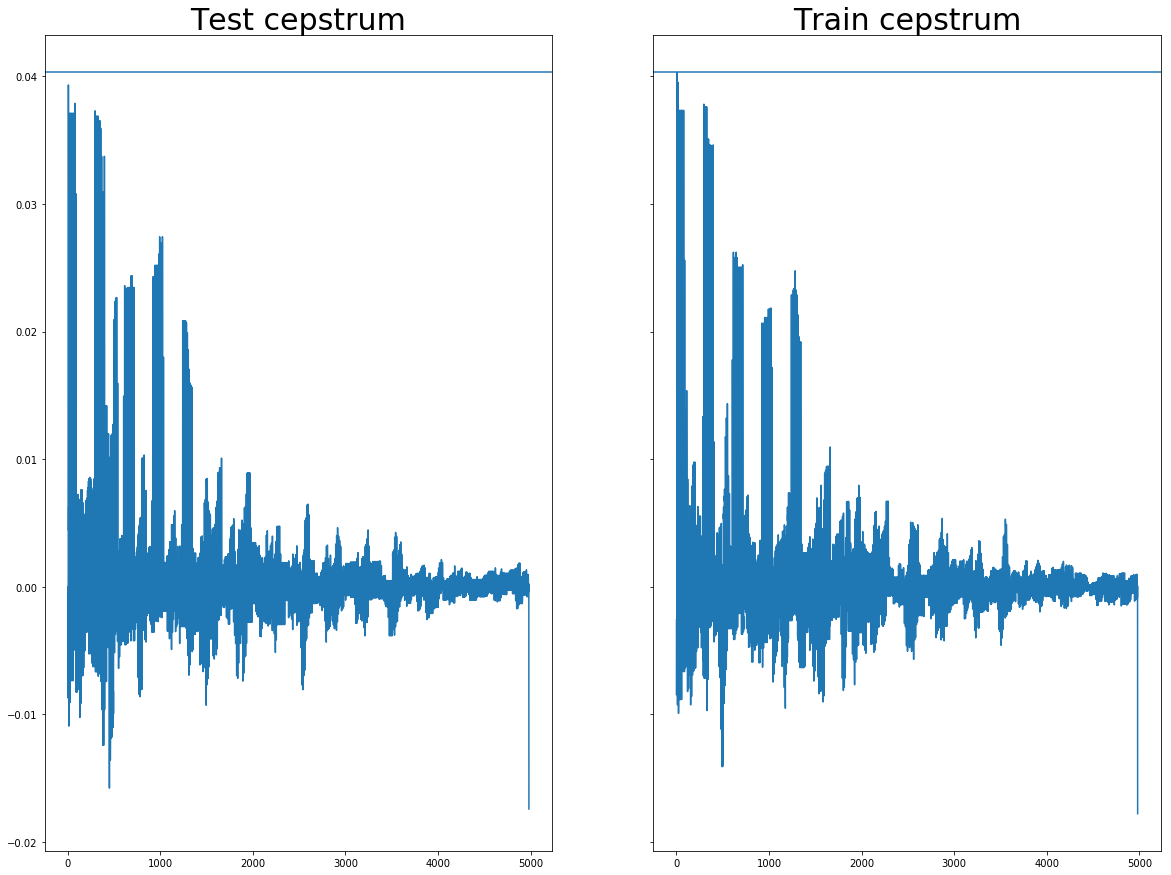

In [19]:
fig , (ax1 , ax2) = plt.subplots(1,2,sharey=True,figsize=(20,15))
ax1.axhline(cepstrum_train_max)
ax1.plot(cepstrum_test_means_over_time)
ax1.set_title('Test cepstrum',fontsize=30)
ax2.axhline(cepstrum_train_max)
ax2.plot(cepstrum_train_means_over_time)
ax2.set_title('Train cepstrum' , fontsize=30)
plt.show()

In [ ]:
sweep_freq = fft_train[:,250] - np.mean(fft_train[:,250])
fig , (ax1 , ax2) = plt.subplots(2,1,figsize=(10,10))
cepstrum_sample_plot_path = os.path.join(data_dir,"cepstrum_sample.png")
ax1.plot(sweep_freq)
ax1.set_title('Sweep frequency plot')
ax2.plot(np.abs(compute_frequency_spectrum(sweep_freq)))
ax2.set_title('fft of frequency')
plt.show()

In [ ]:
fft2test = np.abs(fft2(fft_test[:,200:300]))

In [ ]:
plot_spectogram(fft2test,test_freqs,test_time)